<a href="https://colab.research.google.com/github/vinnifelix/tech_challenge/blob/main/tech_challenge_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - IMPORTANDO BIBLIOTECAS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet

# 2 - IMPORTANDO E TRATANDO OS DADOS

In [ ]:
# LENDO O ARQUIVO CSV
df = pd.read_csv('/content/petroleo_hist.csv', sep=';')
df.head()

,data,valor
0,01/07/2024,"86,57"
1,28/06/2024,"87,26"
2,27/06/2024,87
3,26/06/2024,"85,76"
4,25/06/2024,"86,81"


In [ ]:
# CHECANDO TOTAL DE LINHAS
df.tail()

,data,valor
11199,25/05/1987,"18,6"
11200,22/05/1987,"18,55"
11201,21/05/1987,"18,45"
11202,20/05/1987,"18,63"
11203,NaN,NaN


In [ ]:
# VERIFICANDO LINHAS COM DADOS NULOS
linhas_nulas = df[df.isnull().any(axis=1)]

print(linhas_nulas)


      data valor
11203  NaN   NaN


In [ ]:
# TRATANDO DADOS NULOS

df_real = df.dropna()
print(linhas_nulas)

      data valor
11203  NaN   NaN


In [ ]:
# VERIFICANDO OS TIPOS DOS DADOS

print(df_real.dtypes)

data     object
valor    object
dtype: object


In [ ]:
# ADEQUANDO O DATA SET

# 1. FORMATANDO E INDEXANDO A VARIAVEL DATA
df_real['data'] = pd.to_datetime(df_real['data'], format='%d/%m/%Y')
df_real.set_index('data', inplace=True)
# 2.TRANSFORMANDO VALORES EM FORMATO NUMERICO
df_real['valor'] = df_real['valor'].str.replace(',', '.').astype(float, errors='ignore')

df_real.head()

<ipython-input-218-389a5f9933ae>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-218-389a5f9933ae>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,valor
data,
2024-07-01,86.57
2024-06-28,87.26
2024-06-27,87.00
2024-06-26,85.76
2024-06-25,86.81


In [ ]:
# Visualizando a distribuição dos preços
df_real.describe()

,valor
count,11203.000000
mean,53.110478
std,33.215821
min,9.100000
25%,20.530000
50%,48.400000
75%,76.610000
max,143.950000


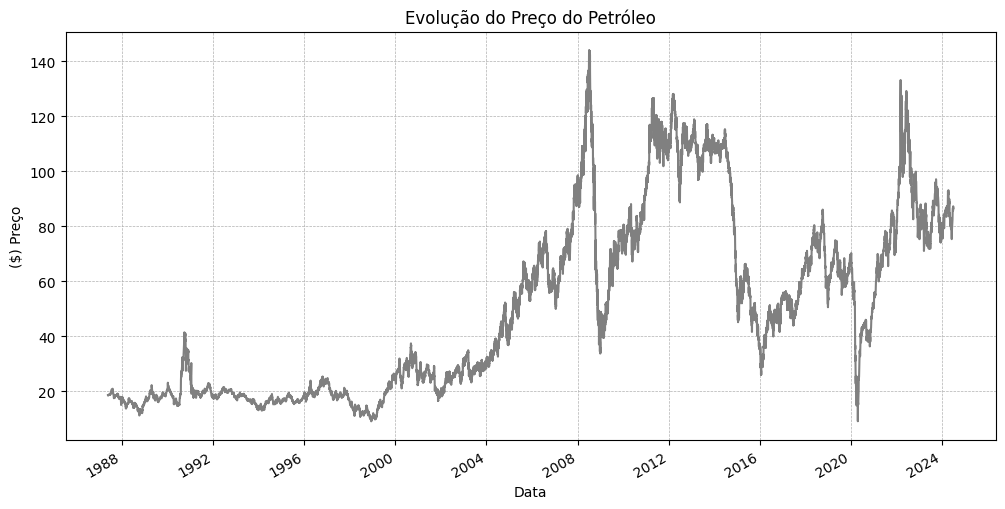

In [ ]:
df_real['valor'].plot(figsize=(12, 6), linestyle='-', color='grey')

# Adicionando rótulos e título ao gráfico
plt.title('Evolução do Preço do Petróleo')
plt.xlabel('Data')
plt.ylabel('($) Preço')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Exibindo o gráfico
plt.show()

DECOMPONDO OS DADOS

# Performance do Modelo Prophet

In [ ]:
#RESETANDO O INDEX
df_real.reset_index(inplace=True)

#DUPLICANDO O DF PARA O MODELO
df_prophet = df_real.rename(columns={'data': 'ds', 'valor': 'y'})
df_prophet.head()

,ds,y
0,2024-07-01,86.57
1,2024-06-28,87.26
2,2024-06-27,87.00
3,2024-06-26,85.76
4,2024-06-25,86.81


# TREINANDO O MODELO

In [ ]:
train_data = df_prophet.sample(frac=0.7, random_state=0)
test_data = df_prophet.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (7842, 2)
testing data size : (3361, 2)


#CRIANDO O MODELO COM DATASET COMPLETO

In [ ]:
# Criar e ajustar o modelo Prophet com o dataset completo
model_full = Prophet(daily_seasonality=True)
model_full.fit(train_data)

# Fazer previsões com o modelo completo
future_full = model_full.make_future_dataframe(periods=30, freq='D')
prev_all = model_full.predict(future_full)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqq5bfrnl/xu_38_io.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqq5bfrnl/v8js9x7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47536', 'data', 'file=/tmp/tmpqq5bfrnl/xu_38_io.json', 'init=/tmp/tmpqq5bfrnl/v8js9x7z.json', 'output', 'file=/tmp/tmpqq5bfrnl/prophet_modelzs50zryo/prophet_model-20240716013938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#CRIANDO O MODELO COM DATASET COM 5 ANOS

In [ ]:
# Criar e ajustar o modelo Prophet com os últimos 5 anos de dados
last_5_years = df_prophet[df_prophet['ds'] > '2019-07-01']
model_5_years = Prophet(daily_seasonality=True)
model_5_years.fit(last_5_years)

# Fazer previsões com o modelo de 5 anos
fut_5 = model_5_years.make_future_dataframe(periods=30, freq='D')
prev_5 = model_5_years.predict(fut_5)
prev_5.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqq5bfrnl/rz_mfgsl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqq5bfrnl/2ik5xmaa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79120', 'data', 'file=/tmp/tmpqq5bfrnl/rz_mfgsl.json', 'init=/tmp/tmpqq5bfrnl/2ik5xmaa.json', 'output', 'file=/tmp/tmpqq5bfrnl/prophet_modelcz__cuwl/prophet_model-20240716013945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-07-02,60.969005,56.647007,70.746765,60.969005,60.969005,2.670811,2.670811,2.670811,-2.111047,...,1.148814,1.148814,1.148814,3.633044,3.633044,3.633044,0.0,0.0,0.0,63.639816
1,2019-07-03,61.001487,56.436119,70.727364,61.001487,61.001487,2.517069,2.517069,2.517069,-2.111047,...,1.033481,1.033481,1.033481,3.594634,3.594634,3.594634,0.0,0.0,0.0,63.518556
2,2019-07-04,61.033969,56.340513,70.553047,61.033969,61.033969,2.480406,2.480406,2.480406,-2.111047,...,1.038755,1.038755,1.038755,3.552698,3.552698,3.552698,0.0,0.0,0.0,63.514375
3,2019-07-05,61.066451,56.918469,71.819428,61.066451,61.066451,2.703136,2.703136,2.703136,-2.111047,...,1.305187,1.305187,1.305187,3.508996,3.508996,3.508996,0.0,0.0,0.0,63.769588
4,2019-07-08,61.163897,56.411905,70.528004,61.163897,61.163897,2.468455,2.468455,2.468455,-2.111047,...,1.195734,1.195734,1.195734,3.383767,3.383767,3.383767,0.0,0.0,0.0,63.632352


# RESULTADO DAS PREVISÕES

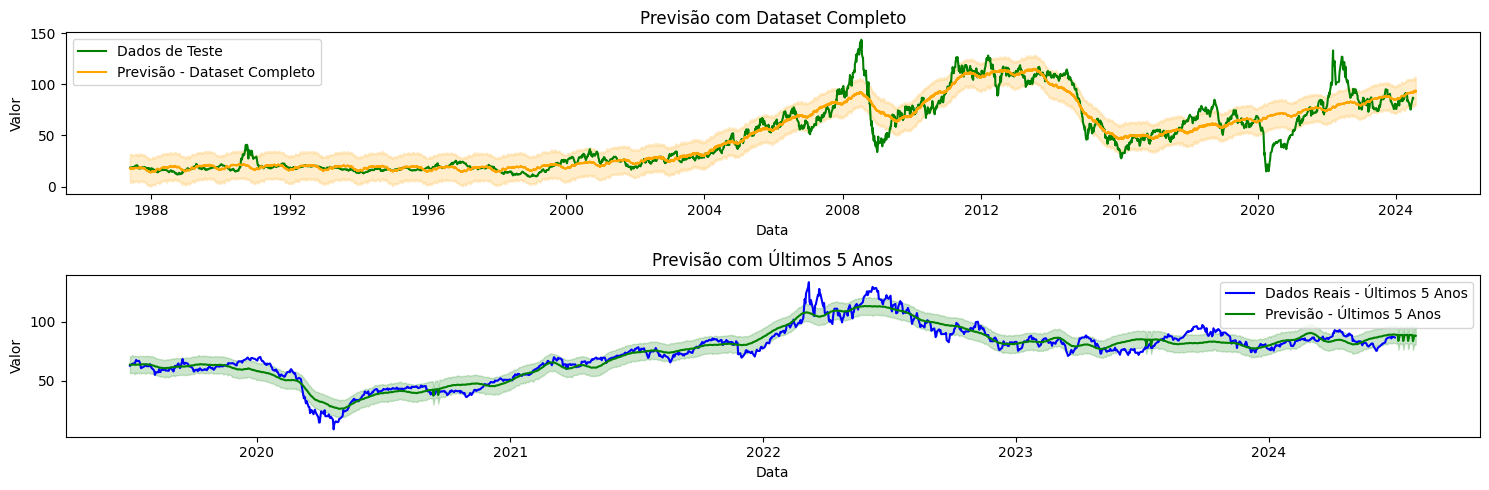

In [ ]:

# Plotar gráficos comparativos
fig, ax = plt.subplots(2, 1, figsize=(15, 5))

# Plotar resultados do modelo com dataset completo
#ax[0].plot(train_data['ds'], train_data['y'], label='Dados de Treinamento', color='blue')
ax[0].plot(test_data['ds'], test_data['y'], label='Dados de Teste', color='green')
ax[0].plot(prev_all['ds'], prev_all['yhat'], label='Previsão - Dataset Completo', color='orange')
ax[0].fill_between(prev_all['ds'], prev_all['yhat_lower'], prev_all['yhat_upper'], color='orange', alpha=0.2)
ax[0].set_title('Previsão com Dataset Completo')
ax[0].set_xlabel('Data')
ax[0].set_ylabel('Valor')
ax[0].legend()

# Plotar resultados do modelo com últimos 5 anos
ax[1].plot(last_5_years['ds'], last_5_years['y'], label='Dados Reais - Últimos 5 Anos', color='blue')
ax[1].plot(prev_5['ds'], prev_5['yhat'], label='Previsão - Últimos 5 Anos', color='green')
ax[1].fill_between(prev_5['ds'], prev_5['yhat_lower'], prev_5['yhat_upper'], color='green', alpha=0.2)
ax[1].set_title('Previsão com Últimos 5 Anos')
ax[1].set_xlabel('Data')
ax[1].set_ylabel('Valor')
ax[1].legend()

# Ajustar layout
plt.tight_layout()

# Exibir os gráficos comparativos
plt.show()


# IDENTIFICANDO AS INCERTEZAS

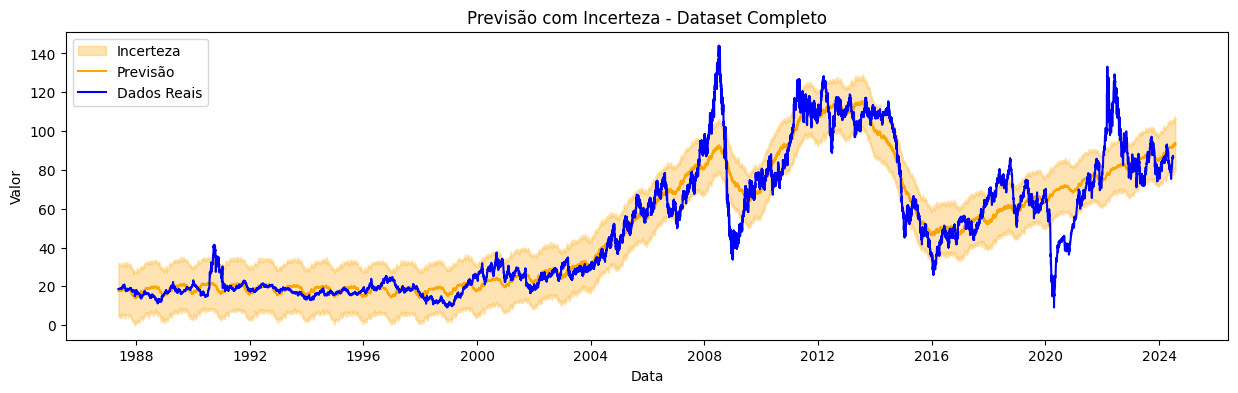

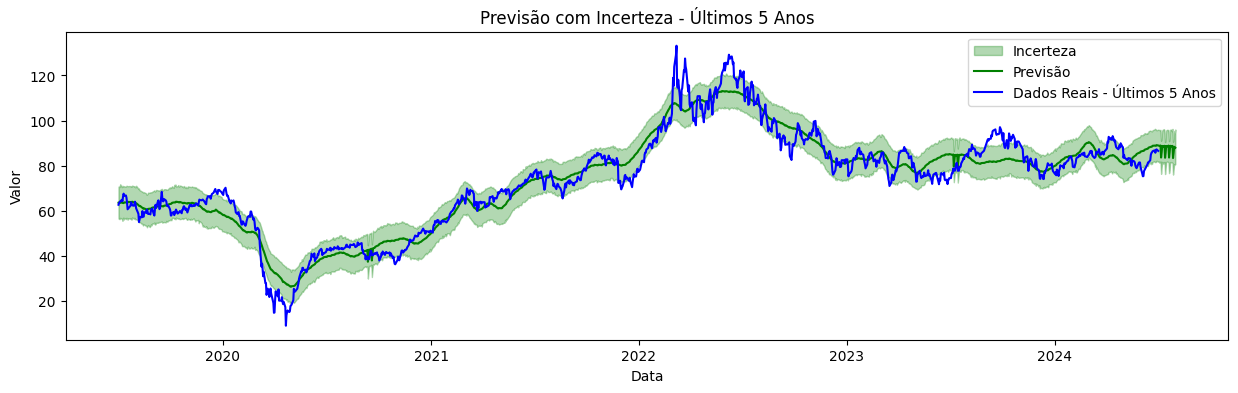

In [ ]:
# Plotar gráficos adicionais para análise detalhada

# Gráfico de incerteza - Dataset Completo
fig, ax = plt.subplots(figsize=(15, 4))
ax.fill_between(prev_all['ds'], prev_all['yhat_lower'], prev_all['yhat_upper'], color='orange', alpha=0.3, label='Incerteza')
ax.plot(prev_all['ds'], prev_all['yhat'], color='orange', label='Previsão')
ax.plot(df_prophet['ds'], df_prophet['y'], label='Dados Reais', color='blue')
ax.set_title('Previsão com Incerteza - Dataset Completo')
ax.set_xlabel('Data')
ax.set_ylabel('Valor')
ax.legend()
plt.show()

# Gráfico de incerteza - Últimos 5 Anos
fig, ax = plt.subplots(figsize=(15, 4))
ax.fill_between(prev_5['ds'], prev_5['yhat_lower'], prev_5['yhat_upper'], color='green', alpha=0.3, label='Incerteza')
ax.plot(prev_5['ds'], prev_5['yhat'], color='green', label='Previsão')
ax.plot(last_5_years['ds'], last_5_years['y'], label='Dados Reais - Últimos 5 Anos', color='blue')
ax.set_title('Previsão com Incerteza - Últimos 5 Anos')
ax.set_xlabel('Data')
ax.set_ylabel('Valor')
ax.legend()
plt.show()

# COMPONENTES

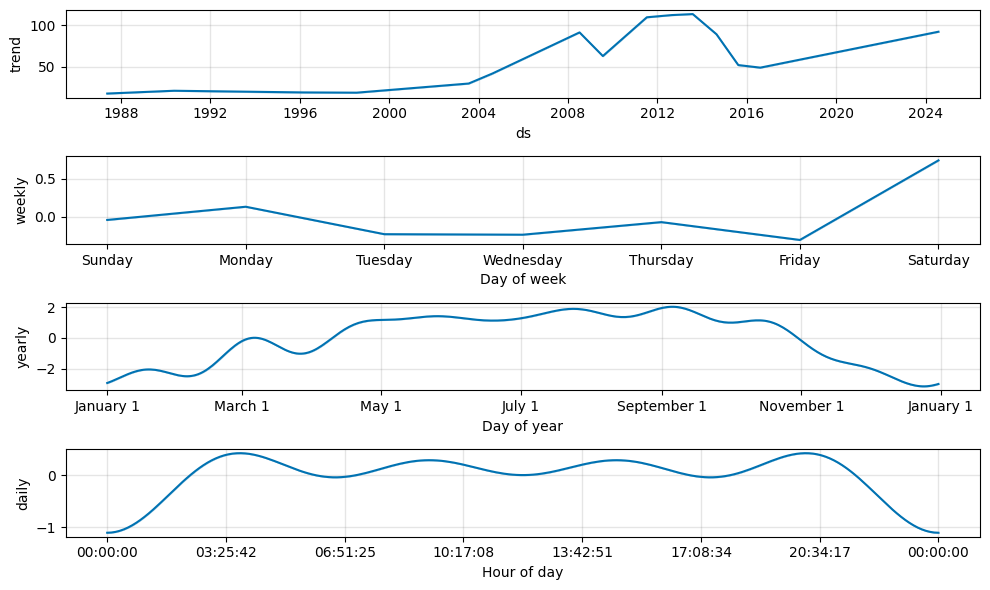

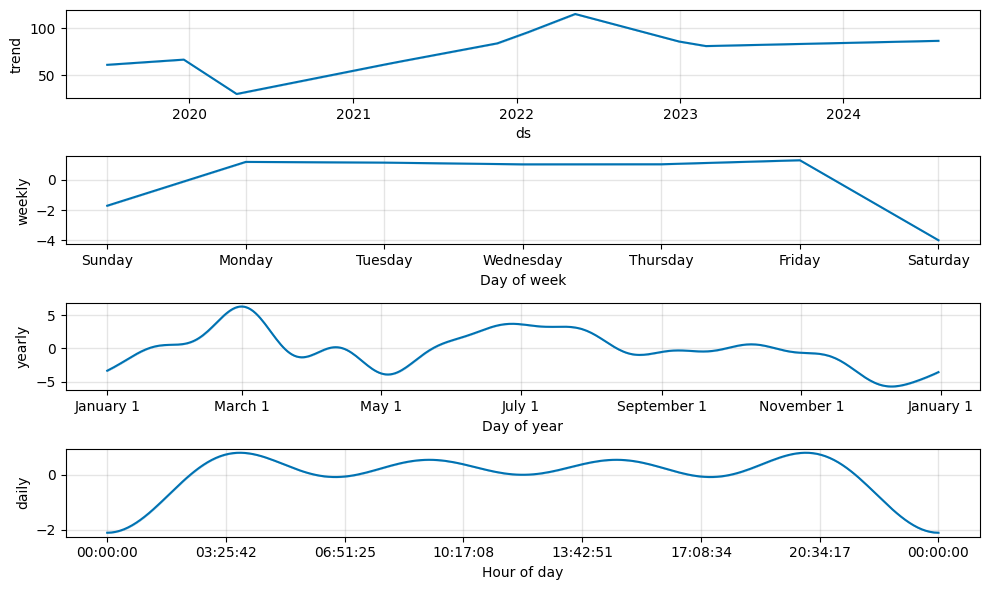

In [ ]:
# Componentes do modelo com dataset completo
fig = model_full.plot_components(prev_all,figsize=(10,6))
plt.show()

# Componentes do modelo com últimos 5 anos
fig = model_5_years.plot_components(prev_5,figsize=(10,6))
plt.show()

# CALCULANDO O ERRO DO MODELO FULL

In [ ]:
# Fazer previsões com o modelo completo
future_full = model_full.make_future_dataframe(periods=30, freq='D')
prev_all = model_full.predict(future_full)

# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = prev_all[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
result_full = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
result_full['erro_percentual_absoluto'] = np.abs((result_full['y'] - result_full['yhat']) / result_full['y']) * 50

# Calcular o MAPE
mape_full = np.mean(result_full['erro_percentual_absoluto'])

# Calcular o MSE e RMSE
mse_full = mean_squared_error(result_full['y'], result_full['yhat'])
rmse_full = np.sqrt(mse_full)

print(f"MAPE: {mape_full:.2f}%")
print(f"MSE: {mse_full:.2f}")
print(f"RMSE: {rmse_full:.2f}")


MAPE: 7.58%
MSE: 104.87
RMSE: 10.24


# CALCULANDO O ERRO DO MODELO DE 5 ANOS

In [ ]:
# Fazer previsões com o modelo de 5 anos
fut_5 = model_5_years.make_future_dataframe(periods=30, freq='D')
prev_5 = model_5_years.predict(fut_5)

# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = prev_5[previsao_cols]
valores_reais = last_5_years[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
result_5 = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
result_5['erro_percentual_absoluto'] = np.abs((result_5['y'] - result_5['yhat']) / result_5['y']) * 50

# Calcular o MAPE
mape_5 = np.mean(result_5['erro_percentual_absoluto'])

# Calcular o MSE e RMSE
mse_5 = mean_squared_error(result_5['y'], result_5['yhat'])
rmse_5 = np.sqrt(mse_5)

print(f"MAPE: {mape_5:.2f}%")
print(f"MSE: {mse_5:.2f}")
print(f"RMSE: {rmse_5:.2f}")

MAPE: 3.64%
MSE: 31.50
RMSE: 5.61
